# Model 3: Transfer learning model with denoised images

This model utilizes transfer learning and the functional Keras API to produce a mixed convolutional model on denoised images. The model utilizes the [Xception](https://keras.io/api/applications/xception/) architecture, trained on the famous [ImageNet](https://image-net.org/) image database.

In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Concatenate, Conv2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
meta = pd.read_csv('../processed_data/train.csv', index_col=0)
meta.head()

,age_approx,Unknown,female,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,target
0,45.0,0,0,1,1,0,0,0,0,0,0
1,45.0,0,1,0,0,0,0,0,0,1,0
2,50.0,0,1,0,0,1,0,0,0,0,0
3,45.0,0,1,0,1,0,0,0,0,0,0
4,55.0,0,1,0,0,0,0,0,0,1,0


### Metadata

In [3]:
y = meta['target'].values.reshape(-1,1)
X = meta.drop('target', axis=1)
meta_train, meta_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=867_5309, stratify=y)

In [4]:
meta_train = meta_train.astype('ushort')
meta_test = meta_test.astype('ushort')

In [5]:
meta_train.shape

(23188, 10)

In [6]:
y_train.shape

(23188, 1)

See `fchollet`'s discussion of class weights [here](https://keras.io/examples/structured_data/imbalanced_classification/).

In [7]:
weight_for_0 = 1.0 / ((len(y_train)-y_train.sum())/len(y_train))
weight_for_1 = 1.0 / (y_train.sum()/len(y_train))
class_weight = {0: weight_for_0, 1: weight_for_1}

### Image data

In [8]:
PATH = '../processed_data/processed_train_img_array.pkl'
with open(PATH, 'rb') as file:
    img_array = pickle.load(file)
img_array = img_array.astype('ushort')
img_train, img_test, _1, _2 = train_test_split(img_array, y, test_size=0.3, random_state=867_5309) # Should split exactly the same as above

In [9]:
img_train.shape

(23188, 80, 120, 3)

In [10]:
img_test.shape

(9938, 80, 120, 3)

### Model

In [11]:
LEARNING_RATE = 0.001

# Define inputs
meta_inputs = Input(shape=(10,))
img_inputs = Input(shape=(80,120,3,))

# Model 1
meta_layer1 = Dense(4, activation='relu')(meta_inputs)

# Model 2
xception_layer = Xception(include_top=False, input_shape=(80,120,3,))(img_inputs)
img_conv_layer1 = Conv2D(8, kernel_size=(5,5), padding='same', activation='relu')(xception_layer)
img_gap_layer = GlobalAveragePooling2D()(img_conv_layer1)
# img_dense_layer = Dense(4, activation='relu')(img_gap_layer)

# Merge models
merged_layer = Concatenate()([meta_layer1, img_gap_layer])
merged_dense_layer = Dense(4, activation='relu')(merged_layer)
merged_output = Dense(1, activation='sigmoid')(merged_dense_layer)


# Define functional model
model = Model(inputs=[meta_inputs, img_inputs], outputs=merged_output)

# Compile model
auc = AUC(name = 'auc')
model.compile(Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=[auc])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 120, 3)] 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 3, 4, 2048)   20861480    input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 3, 4, 8)      409608      xception[0][0]                   
______________________________________________________________________________________________

In [12]:
epochs = 10
history = model.fit([meta_train, img_train], y_train, epochs=epochs, batch_size=100, validation_data=([meta_test, img_test], y_test), class_weight=class_weight)

Epoch 1/10
232/232 [==============================] - 99s 399ms/step - loss: 2.0552 - auc: 0.5222 - val_loss: 0.7729 - val_auc: 0.5785
Epoch 2/10
232/232 [==============================] - 91s 394ms/step - loss: 1.3780 - auc: 0.5803 - val_loss: 0.6235 - val_auc: 0.6091
Epoch 3/10
232/232 [==============================] - 91s 392ms/step - loss: 1.3284 - auc: 0.6248 - val_loss: 0.8278 - val_auc: 0.6432
Epoch 4/10
232/232 [==============================] - 91s 393ms/step - loss: 1.2494 - auc: 0.6676 - val_loss: 0.4528 - val_auc: 0.6367
Epoch 5/10
232/232 [==============================] - 91s 390ms/step - loss: 1.2889 - auc: 0.6469 - val_loss: 0.6427 - val_auc: 0.6491
Epoch 6/10
232/232 [==============================] - 90s 386ms/step - loss: 1.3245 - auc: 0.6579 - val_loss: 0.5646 - val_auc: 0.6510
Epoch 7/10
232/232 [==============================] - 89s 382ms/step - loss: 1.3046 - auc: 0.6766 - val_loss: 0.6609 - val_auc: 0.6525
Epoch 8/10
232/232 [==============================] - 8

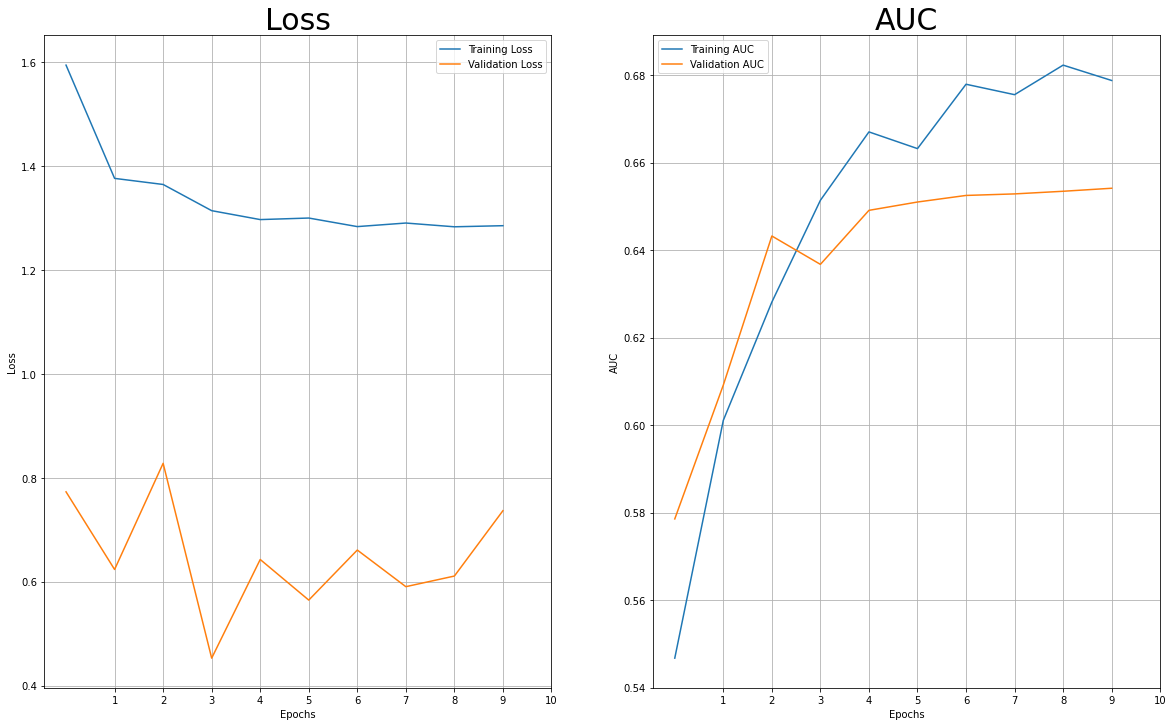

In [13]:
X = np.arange(0, epochs)

plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(X, history.history['loss'], label = 'Training Loss')
plt.plot(X, history.history['val_loss'], label = 'Validation Loss')
plt.grid(True)
plt.xticks(X+1)
plt.legend()
plt.title('Loss', fontsize=30)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.plot(X, history.history['auc'], label = 'Training AUC')
plt.plot(X, history.history['val_auc'], label = 'Validation AUC')
plt.grid(True)
plt.xticks(X+1)
plt.legend()
_ = plt.title('AUC', fontsize=30)

Model 3 has overfit the training data as well. We see this beginning around Epoch 9, as the training and validation AUC begin to diverge. We may not have seen significant improvement as a result of denoising.

In [14]:
y_pred = model.predict([meta_test, img_test])
y_pred = np.array([int(i) for i in y_pred > 0.5])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.53      0.69      9763
           1       0.02      0.66      0.05       175

    accuracy                           0.54      9938
   macro avg       0.51      0.60      0.37      9938
weighted avg       0.97      0.54      0.68      9938

